In [1]:
import torch
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW

In [2]:
# Specify the path to your CSV file
csv_file_path = '/content/ar_reviews_100k.tsv'

# Read the TSV file into a Pandas DataFrame
ar_tweets = pd.read_csv(csv_file_path, sep='\t')

# Create a mapping dictionary
label_mapping = {'Positive': 2, 'Mixed': 1, 'Negative': 0}

# Replace the values in the "label" column with the corresponding numeric values
ar_tweets['label'] = ar_tweets['label'].map(label_mapping)

# Rename the "label" column to "target"
ar_tweets.rename(columns={'label': 'target'}, inplace=True)

In [3]:
ar_tweets

,target,text
0,2,ممتاز نوعا ما . النظافة والموقع والتجهيز والشا...
1,2,أحد أسباب نجاح الإمارات أن كل شخص في هذه الدول...
2,2,هادفة .. وقوية. تنقلك من صخب شوارع القاهرة الى...
3,2,خلصنا .. مبدئيا اللي مستني ابهار زي الفيل الاز...
4,2,ياسات جلوريا جزء لا يتجزأ من دبي . فندق متكامل...
...,...,...
99994,0,معرفش ليه كنت عاوزة أكملها وهي مش عاجباني من ا...
99995,0,لا يستحق ان يكون في بوكنق لانه سيئ . لا شي. لا...
99996,0,كتاب ضعيف جدا ولم استمتع به. فى كل قصه سرد لحا...
99997,0,مملة جدا. محمد حسن علوان فنان بالكلمات، والوصف...


In [4]:
# Assuming your CSV file has columns 'text' and 'label'
data = list(zip(ar_tweets['text'].astype(str), ar_tweets['target'].astype(str)))  # Ensure the 'text' and 'label' columns are treated as strings

In [5]:
# Split the dataset into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

In [6]:
# Define a custom dataset class
class SentimentDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=128):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text, label = self.data[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(int(label))  # Assuming labels are integers representing the class index
        }

In [7]:
# Load the BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=3)

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
# Create datasets and dataloaders
train_dataset = SentimentDataset(train_data, tokenizer)
test_dataset = SentimentDataset(test_data, tokenizer)
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [9]:
# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [11]:
# Training loop
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
num_epochs = 4

In [ ]:
# # Training loop
# for epoch in range(num_epochs):
#     model.train()
#     for batch in tqdm(train_dataloader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
#         inputs = {key: val.to(device) for key, val in batch.items() if key != 'label'}
#         labels = batch['label'].to(device)

#         optimizer.zero_grad()
#         outputs = model(**inputs, labels=labels)
#         loss = outputs.loss
#         loss.backward()
#         optimizer.step()

Epoch 2/2: 100%|██████████| 2000/2000 [07:49<00:00,  4.26it/s]


In [12]:
from sklearn.metrics import accuracy_score

In [13]:
# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    all_preds = []
    all_labels = []

    for batch in tqdm(train_dataloader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        inputs = {key: val.to(device) for key, val in batch.items() if key != 'label'}
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(**inputs, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Get model predictions
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy
    accuracy = accuracy_score(all_labels, all_preds)

    # Print loss and accuracy
    avg_loss = total_loss / len(train_dataloader)
    print(f'Epoch {epoch + 1}/{num_epochs} - Average Loss: {avg_loss:.4f} - Accuracy: {accuracy:.4f}')

Epoch 1/4: 100%|██████████| 10000/10000 [38:25<00:00,  4.34it/s]


Epoch 1/4 - Average Loss: 0.7609 - Accuracy: 0.6312


Epoch 2/4: 100%|██████████| 10000/10000 [38:26<00:00,  4.34it/s]


Epoch 2/4 - Average Loss: 0.6697 - Accuracy: 0.6936


Epoch 3/4: 100%|██████████| 10000/10000 [38:21<00:00,  4.34it/s]


Epoch 3/4 - Average Loss: 0.6172 - Accuracy: 0.7230


Epoch 4/4: 100%|██████████| 10000/10000 [38:25<00:00,  4.34it/s]

Epoch 4/4 - Average Loss: 0.5662 - Accuracy: 0.7504


In [14]:
# Evaluation
model.eval()
predictions, true_labels = [], []
for batch in tqdm(test_dataloader, desc='Evaluating'):
    inputs = {key: val.to(device) for key, val in batch.items() if key != 'label'}
    labels = batch['label'].to(device)

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    predictions.extend(torch.argmax(logits, dim=1).cpu().numpy())
    true_labels.extend(labels.cpu().numpy())

Evaluating: 100%|██████████| 2500/2500 [02:44<00:00, 15.24it/s]


In [15]:
# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.6975


In [16]:
# Save model locally in Colab
model.save_pretrained('/content/sentimental_analysis_model')
tokenizer.save_pretrained('/content/tokenizer')

('/content/tokenizer/tokenizer_config.json',
 '/content/tokenizer/special_tokens_map.json',
 '/content/tokenizer/vocab.txt',
 '/content/tokenizer/added_tokens.json')

In [17]:
from sklearn.metrics import confusion_matrix, classification_report

In [18]:
# Calculate confusion matrix and classification report
conf_matrix = confusion_matrix(true_labels, predictions)
class_report = classification_report(true_labels, predictions)

# Display confusion matrix and classification report
print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

Confusion Matrix:
[[5134  864  605]
 [1479 3380 1863]
 [ 490  750 5435]]

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.78      0.75      6603
           1       0.68      0.50      0.58      6722
           2       0.69      0.81      0.75      6675

    accuracy                           0.70     20000
   macro avg       0.70      0.70      0.69     20000
weighted avg       0.70      0.70      0.69     20000



Testing Dataset Label Distribution:
1    6722
2    6675
0    6603
dtype: int64
True: 2, Predicted: 1
True: 0, Predicted: 0
True: 2, Predicted: 2
True: 0, Predicted: 0
True: 1, Predicted: 1
True: 0, Predicted: 0
True: 1, Predicted: 1
True: 0, Predicted: 0
True: 1, Predicted: 1
True: 1, Predicted: 0


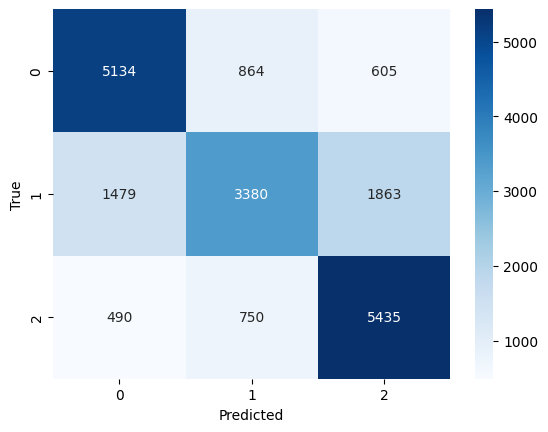

In [19]:
# Print the distribution of labels in the testing dataset
print("Testing Dataset Label Distribution:")
print(pd.Series(true_labels).value_counts())

# Print true labels and predicted labels for a small sample
for true, pred in zip(true_labels[:10], predictions[:10]):
    print(f"True: {true}, Predicted: {pred}")

# Plot the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()